各阶段的决策、成本和收益：
     阶段      选择  不检测/丢弃成本  检测/拆解成本        不检测收益        检测收益
0   零配件  不检测或丢弃      72.0     83.0     0.000000     0.00000
1   半成品  不检测或丢弃      96.0    119.0     0.000000     0.00000
2    成品  不检测或丢弃     104.0    133.0     0.000000     0.00000
3  成品处理   检测或拆解     144.0    143.0  1541.605404  1569.05298


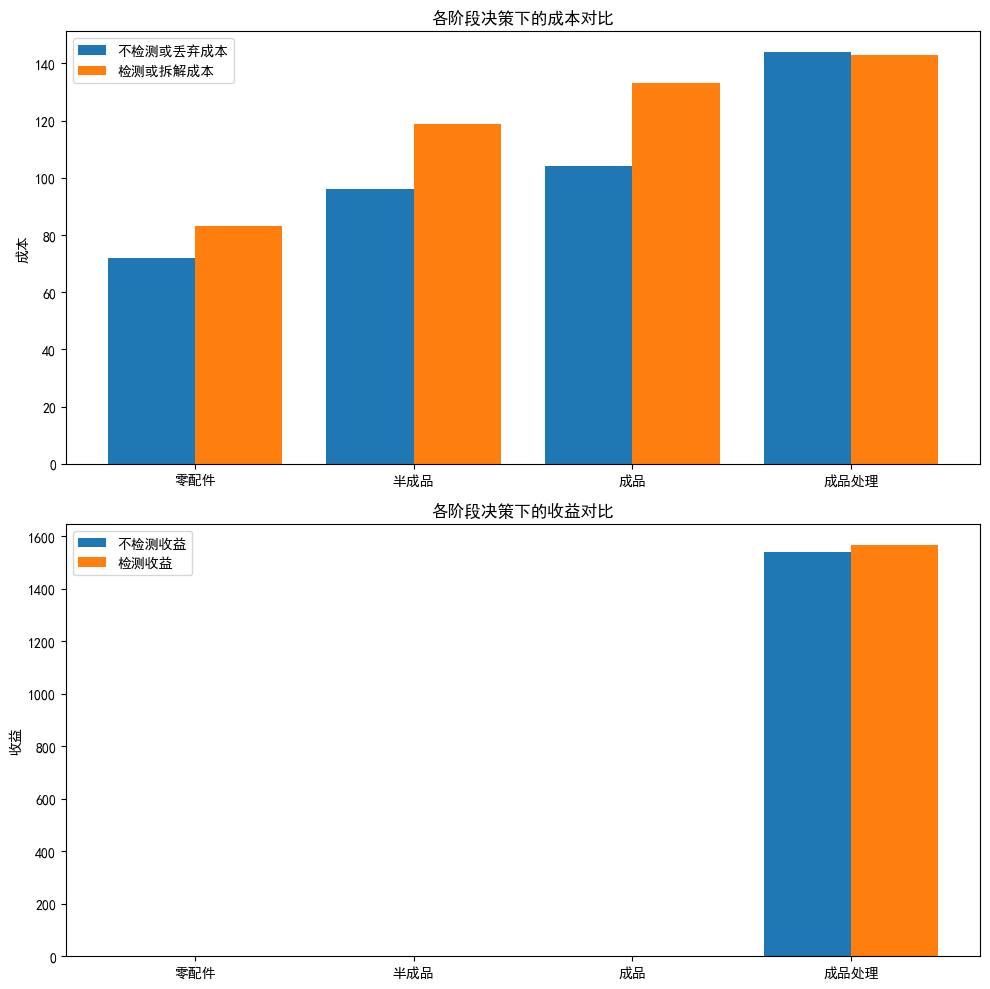

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义基本参数
component_defects = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  # 零配件次品率
component_assemble_costs = [6, 10, 10, 4, 8, 12, 10, 12]  # 零配件装配成本
component_detection_costs = [1, 1, 2, 1, 1, 2, 1, 2]  # 零配件检测成本

semi_defects = [0.1, 0.1, 0.1]  # 半成品次品率
semi_assemble_costs = [8, 8, 8]  # 半成品装配成本
semi_detection_costs = [4, 4, 4]  # 半成品检测成本

final_defects = 0.1  # 成品次品率
final_assemble_cost = 8  # 成品装配成本
final_detection_cost = 6  # 成品检测成本
final_disassembly_cost = 10  # 成品拆解费用
market_price = 50  # 市场售价
replacement_loss = 40  # 调换损失


# 定义函数：计算成品合格率
def calculate_final_product_defect_rate(component_defects, semi_defects):
    # 合成零配件和半成品的合格率
    overall_component_defect = 1 - np.prod([1 - d for d in component_defects])
    overall_semi_defect = 1 - np.prod([1 - d for d in semi_defects])
    final_defect_rate = (
        overall_component_defect
        + overall_semi_defect
        - overall_component_defect * overall_semi_defect
    )
    return final_defect_rate


# 定义函数：计算某一阶段的最小成本和收益
def calculate_cost_and_profit():
    # 计算零配件阶段是否检测
    component_costs_with_detection = []
    component_costs_without_detection = []
    effective_component_defects = []

    for i in range(8):
        # 检测时，不合格零件会被丢弃，检测成本+装配成本+丢弃损失
        cost_with_detection = component_detection_costs[i] + component_assemble_costs[i]
        # 不检测时，直接装配，无检测成本
        cost_without_detection = component_assemble_costs[i]
        # 检测后的不合格率为0，不检测的不合格率保持原值
        effective_defect_with_detection = 0
        effective_defect_without_detection = component_defects[i]

        component_costs_with_detection.append(cost_with_detection)
        component_costs_without_detection.append(cost_without_detection)
        effective_component_defects.append(
            (effective_defect_with_detection, effective_defect_without_detection)
        )

    # 计算半成品阶段是否检测
    semi_costs_with_detection = []
    semi_costs_without_detection = []
    effective_semi_defects = []

    for i in range(3):
        cost_with_detection = semi_detection_costs[i] + semi_assemble_costs[i]
        cost_without_detection = semi_assemble_costs[i]
        # 检测后的不合格率为0，不检测的不合格率保持原值
        effective_defect_with_detection = 0
        effective_defect_without_detection = semi_defects[i]

        semi_costs_with_detection.append(cost_with_detection)
        semi_costs_without_detection.append(cost_without_detection)
        effective_semi_defects.append(
            (effective_defect_with_detection, effective_defect_without_detection)
        )

    # 成品阶段是否检测
    final_cost_with_detection = final_detection_cost + final_assemble_cost
    final_cost_without_detection = final_assemble_cost

    # 成品不合格是否拆解
    disassembly_cost = final_disassembly_cost
    discard_cost = replacement_loss

    # 计算收益（市场售出收益与不合格成品调换损失）
    final_product_defect_rate = calculate_final_product_defect_rate(
        component_defects, semi_defects
    )

    # 不检测时，考虑调换损失
    revenue_if_sold_without_detection = (
        market_price * (1 - final_product_defect_rate)
    ) - (replacement_loss * final_product_defect_rate)
    # 检测时，只有合格的成品进入市场，无调换损失
    revenue_if_sold_with_detection = market_price * (1 - final_product_defect_rate)

    return {
        "零配件检测": component_costs_with_detection,
        "零配件不检测": component_costs_without_detection,
        "半成品检测": semi_costs_with_detection,
        "半成品不检测": semi_costs_without_detection,
        "成品检测": final_cost_with_detection,
        "成品不检测": final_cost_without_detection,
        "成品拆解": disassembly_cost,
        "成品丢弃": discard_cost,
        "市场收益_检测": revenue_if_sold_with_detection,
        "市场收益_不检测": revenue_if_sold_without_detection,
        "effective_component_defects": effective_component_defects,
        "effective_semi_defects": effective_semi_defects,
    }


# 执行动态规划计算最优解
def dynamic_programming():
    results = calculate_cost_and_profit()

    # 初始化阶段
    dp_cost = np.zeros((4, 2))  # 状态表示 dp_cost[i][j]，表示第i阶段，选择j的最小成本
    dp_revenue = np.zeros((4, 2))  # 收益部分

    # 第1阶段：零配件检测
    dp_cost[0][0] = sum(results["零配件不检测"])  # 全部不检测的成本
    dp_cost[0][1] = sum(results["零配件检测"])  # 全部检测的成本

    # 第2阶段：半成品检测
    dp_cost[1][0] = dp_cost[0][0] + sum(
        results["半成品不检测"]
    )  # 零配件不检测，半成品不检测
    dp_cost[1][1] = dp_cost[0][1] + sum(results["半成品检测"])  # 零配件检测，半成品检测

    # 第3阶段：成品检测
    dp_cost[2][0] = dp_cost[1][0] + results["成品不检测"]  # 前两阶段不检测，成品不检测
    dp_cost[2][1] = dp_cost[1][1] + results["成品检测"]  # 前两阶段检测，成品检测

    # 第4阶段：成品拆解或丢弃
    dp_cost[3][0] = dp_cost[2][0] + results["成品丢弃"]  # 前三阶段不检测，丢弃成品
    dp_cost[3][1] = dp_cost[2][1] + results["成品拆解"]  # 前三阶段检测，拆解成品

    # 收益计算
    dp_revenue[3][0] = results["市场收益_不检测"]  # 不检测直接售出
    dp_revenue[3][1] = results["市场收益_检测"]  # 检测后售出

    # 返回最优成本和收益
    return dp_cost, dp_revenue, results


# 生成决策表格，包含成本和收益
def create_decision_table(dp_cost, dp_revenue, results):
    stages = ["零配件", "半成品", "成品", "成品处理"]
    actions = ["不检测或丢弃", "检测或拆解"]

    # 获取每个阶段的最优选择
    decisions = []
    for i in range(4):
        if dp_cost[i][0] < dp_cost[i][1]:
            decisions.append("不检测或丢弃")
        else:
            decisions.append("检测或拆解")

    # 生成表格数据
    data = {
        "阶段": stages,
        "选择": decisions,
        "不检测/丢弃成本": dp_cost[:, 0],
        "检测/拆解成本": dp_cost[:, 1],
        "不检测收益": dp_revenue[:, 0],
        "检测收益": dp_revenue[:, 1],
    }

    return pd.DataFrame(data)


# 执行动态规划并生成表格
dp_cost_results, dp_revenue_results, results = dynamic_programming()
decision_table = create_decision_table(dp_cost_results, dp_revenue_results, results)

# 打印表格
print("各阶段的决策、成本和收益：")
print(decision_table)
# 保存表格
decision_table.to_excel("决策表格.xlsx", index=False)
# 设置字体为中文
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False


# 可视化比较
def visualize_cost_and_revenue():
    stages = ["零配件", "半成品", "成品", "成品处理"]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # 绘制成本对比
    width = 0.4
    x = np.arange(len(stages))

    ax1.bar(x - width / 2, dp_cost_results[:, 0], width, label="不检测或丢弃成本")
    ax1.bar(x + width / 2, dp_cost_results[:, 1], width, label="检测或拆解成本")

    ax1.set_ylabel("成本")
    ax1.set_title("各阶段决策下的成本对比")
    ax1.set_xticks(x)
    ax1.set_xticklabels(stages)
    ax1.legend()

    # 绘制收益对比
    ax2.bar(x - width / 2, dp_revenue_results[:, 0], width, label="不检测收益")
    ax2.bar(x + width / 2, dp_revenue_results[:, 1], width, label="检测收益")

    ax2.set_ylabel("收益")
    ax2.set_title("各阶段决策下的收益对比")
    ax2.set_xticks(x)
    ax2.set_xticklabels(stages)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # 保存可视化结果
    fig.savefig("成本收益对比.png")


# 显示可视化结果
visualize_cost_and_revenue()
